# Word2Vec Examples

Two simple examples using the Python implementation of Word2Vec in the gensim library. External files are available as part of the [ACM-BCB 2019 tutorial on GitHub](https://github.com/riti4538/ACM-BCB-2019-Tutorial) or separately online:

- [Google News embedding](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)
- [Wikipedia2Vec embeddings](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/)
- [GloVe embeddings](https://nlp.stanford.edu/projects/glove/)
- [Analogy test file](https://github.com/nicholas-leonard/word2vec/blob/master/questions-words.txt)

The original Word2Vec papers:

- Mikolov, Tomas, et. al. [Efficient estimation of word representations in vector space.](https://arxiv.org/pdf/1301.3781.pdf%5D) *Advances in neural information processing systems* (2013).
- Mikolov, Tomas, et. al. [Distributed representations of words and phrases and their compositionality.](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) *arXiv preprint arXiv:1301.3781* (2013).

BioVec paper:

- Asgari, Ehsaneddin, and Mohammad RK Mofrad. [Continuous distributed representation of biological sequences for deep proteomics and genomics.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0141287) *PloS one* 10.11 (2015): e0141287.

Other useful resources:

- gensim documentation
    - [General](https://radimrehurek.com/gensim/)
    - [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) 
- [Google code archive](https://code.google.com/archive/p/word2vec/)


In [11]:
import gensim
from gensim import models
import gensim.downloader as api
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings;
warnings.filterwarnings('ignore');
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Natural Language Processing

Training a full Word2Vec model often takes a significant amount of time and training data. While I will not be doing this here, it is worth knowing what a call to *models.Word2Vec* looks like in gensim. 

- sentences: A list of lists of words. This can be an iterable.
- size: Dimension of the final embeddings. Between 100 and 300 often works well.
- window: Maximum distance from each target word to consider. This is typically around 10 for the skip-gram architecture and around 5 for CBOW.
- min_count: Minimum number of times a word must occur to be considered.
- sg: 1 for the skip-gram architecture, otherwise CBOW will be used. Skip-gram is generally slower to train but better for infrequent words.
- hs: 1 to use hierarchical softmax, 0 to use negative sampling. Both are techniques to speed up the training process.
    - Hierarchical softmax: Organize the output layer as a Huffman tree. This allows normalization of this layer to be completed in $log(n)$ steps instead of $n$ where $n$ is the size of the vocabulary.
    - Negative sampling: Update the weights of randomly selected negative examples, not the full vocabulary, for each positive example.
- negative: Number of negative examples to consider per positive example. 2-5 work for large datasets, 5-20 for smaller datasets
- iter: The number of training epochs to use. This is usually between 5 and 100. 20-30 seems to work well.
- workers: The number of threads to use during training.

In [12]:
#a function to to yield one line from a file at a time
def genSentences(inFile, num):
    with open(inFile, 'r') as f:
        for i,line in enumerate(f):
            if num>0 and i>num: break
            seq = line.strip()
            if sent: yield gensim.utils.simple_preprocess(sent)

#an iterator over the lines if a file
class SentenceIter:
    def __init__(self, inFile, num=-1):
        self.inFile = inFile
    def __iter__(self):
        return genSentences(self.inFile, self.num)

#create a Word2Vec embedding based on the given set of sentences
def embedText(inFile, numSentences=-1, dim=100):
    sentences = SentenceIter(inFile, num=numSentences)
    model = models.Word2Vec(sentences,
                            size=dim,
                            window=10,
                            min_count=5,
                            sg=1,
                            hs=0,
                            negative=10,
                            iter=5,
                            workers=1)
    return model

Fortunately, there are many pretrained embeddings available online. These can be very useful and can save a tremendous amount of time. However, in order to understand the results of any downstream task, it is important to know the values used for hyperparameters as well as what kind of data was used for training. Do not expect a model trained on Wikipedia entries to perform well when applied to a corpus full of medical jargon.

Loading Word2Vec embedding files is straightforward in gensim. The *load_word2vec_format* function does this directly. It is also possible to convert embeddings generated with other methods, like [GloVe](https://nlp.stanford.edu/pubs/glove.pdf), to the Word2Vec format. Empircally, embeddings resulting from Word2Vec and GloVe tend to have similar performance characteristics on downstream tasks.

You may need to download a pretrained embedding to work with here. Links to several sources are included at the beginning of this notebook.

In [13]:
#convert a GloVe model to a Word2Vec model
def gloveFromW2V(gloveFile, save=''):
    w2vFile = '/'.join(gloveFile.split('/')[:-1]) + 'w2v_'+gloveFile.split('/')[-1]
    glove2word2vec(gloveFile, w2vFile if not save else save)
    return loadW2V(w2vFile)

#load a Word2Vec model
def loadW2V(w2vFile):
    return gensim.models.KeyedVectors.load_word2vec_format(w2vFile, binary=True if ('bin' in w2vFile.split('.')) else False)

googleNews = 'GoogleNews-vectors-negative300.bin.gz'

model = loadW2V(googleNews)

2019-08-30 12:27:46,901 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2019-08-30 12:29:00,881 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


Once we have a model, it can be tested on different kinds analogies. Analogy files are separated into sections by lines begining with a colon followed by a space and a section name, e.g. **: capital-common-countries**. Each line in a section consists of 4 words separated by spaces, e.g. **Athens Greece Baghdad Iraq**.

The *accuracy* function (use *evaluate_word_analogies* instead for gensim 3.8.0) considers each set of 4 words and tries to complete the analogy with the first 3. For example, **Athens** is to **Greece** as **Baghdad** is to what? It does this by performing the vector arithmetic **vec(Baghdad)-vec(Athens)+vec(Greece)** and selecting the closest embedded word as the solution. The function returns lists of correct and incorrect answers broken down by section.

In [14]:
#run the analogy test for a given model and set of questions
def analogyTest(model, testFile='questions-words.txt'):
    results = model.accuracy(testFile)
    print('Section\tCorrect\tIncorrect')
    for d in results:
        print(d['section'], len(d['correct']), len(d['incorrect']))
    total = results[-1]
    acc = float(len(total['correct'])) / float(len(total['correct'])+len(total['incorrect']))
    print('Analogy score: '+str(acc))

analogyTest(model)

2019-08-30 12:29:08,324 : INFO : precomputing L2-norms of word weight vectors
2019-08-30 12:29:13,809 : INFO : capital-common-countries: 83.6% (423/506)
2019-08-30 12:29:20,275 : INFO : capital-world: 82.7% (1144/1383)
2019-08-30 12:29:20,874 : INFO : currency: 39.8% (51/128)
2019-08-30 12:29:31,801 : INFO : city-in-state: 74.6% (1739/2330)
2019-08-30 12:29:33,381 : INFO : family: 90.1% (308/342)
2019-08-30 12:29:37,252 : INFO : gram1-adjective-to-adverb: 32.3% (262/812)
2019-08-30 12:29:39,199 : INFO : gram2-opposite: 50.5% (192/380)
2019-08-30 12:29:45,264 : INFO : gram3-comparative: 91.9% (1224/1332)
2019-08-30 12:29:48,531 : INFO : gram4-superlative: 88.0% (618/702)
2019-08-30 12:29:52,381 : INFO : gram5-present-participle: 79.8% (694/870)
2019-08-30 12:29:57,950 : INFO : gram6-nationality-adjective: 97.1% (1193/1229)
2019-08-30 12:30:04,701 : INFO : gram7-past-tense: 66.5% (986/1482)
2019-08-30 12:30:09,053 : INFO : gram8-plural: 85.6% (849/992)
2019-08-30 12:30:12,336 : INFO : gr

Section	Correct	Incorrect
capital-common-countries 423 83
capital-world 1144 239
currency 51 77
city-in-state 1739 591
family 308 34
gram1-adjective-to-adverb 262 550
gram2-opposite 192 188
gram3-comparative 1224 108
gram4-superlative 618 84
gram5-present-participle 694 176
gram6-nationality-adjective 1193 36
gram7-past-tense 986 496
gram8-plural 849 143
gram9-plural-verbs 484 218
total 10167 3023
Analogy score: 0.7708112206216831


In [15]:
#print top n similarities related to the king/queen analogy
def kingQueenTest(model, n=5):
    nearKing = model.most_similar(positive='king', topn=n)
    nearMan = model.most_similar(positive='man', topn=n)
    nearQueen = model.most_similar(positive='queen', topn=n)
    nearWoman = model.most_similar(positive='woman', topn=n)
    king_queen = model.n_similarity(['king'], ['queen'])
    king_minus_man = model.most_similar(positive=['king'], negative=['man'], topn=n)
    queen_minus_woman = model.most_similar(positive=['queen'], negative=['woman'], topn=n)
    king_to_queen = model.most_similar(positive=['king', 'woman'], negative=['man'], topn=n)
    queen_to_king = model.most_similar(positive=['queen', 'man'], negative=['woman'], topn=n)

    print('********************************')
    print('Most similar to \'king\'')
    for i,w in enumerate(nearKing): print('   '+str(i)+': '+w[0])
    print('Most similar to \'queen\'')
    for i,w in enumerate(nearQueen): print('   '+str(i)+': '+w[0])
    print('Most similar to \'man\'')
    for i,w in enumerate(nearMan): print('   '+str(i)+': '+w[0])
    print('Most similar to \'woman\'')
    for i,w in enumerate(nearWoman): print('   '+str(i)+': '+w[0])
    print('Similarity of \'king\' and \'queen\': '+str(king_queen))
    print('Most similar to \'king\' - \'man\'')
    for i,w in enumerate(king_minus_man): print('   '+str(i)+': '+w[0])
    print('Most similar to \'queen\' - \'woman\'')
    for i,w in enumerate(queen_minus_woman): print('   '+str(i)+': '+w[0])
    print('Most similar to \'king\' - \'man\' + \'woman\'')
    for i,w in enumerate(king_to_queen): print('   '+str(i)+': '+w[0])
    print('Most similar to \'queen\' - \'woman\' + \'man\'')
    for i,w in enumerate(queen_to_king): print('   '+str(i)+': '+w[0])
    print('********************************')
    
kingQueenTest(model, n=5)

********************************
Most similar to 'king'
   0: kings
   1: queen
   2: monarch
   3: crown_prince
   4: prince
Most similar to 'queen'
   0: queens
   1: princess
   2: king
   3: monarch
   4: very_pampered_McElhatton
Most similar to 'man'
   0: woman
   1: boy
   2: teenager
   3: teenage_girl
   4: girl
Most similar to 'woman'
   0: man
   1: girl
   2: teenage_girl
   3: teenager
   4: lady
Similarity of 'king' and 'queen': 0.6510956835386661
Most similar to 'king' - 'man'
   0: kings
   1: queen
   2: Pansy_Ho_Chiu
   3: monarch
   4: kingdom
Most similar to 'queen' - 'woman'
   0: queens
   1: king
   2: kings
   3: royal
   4: kings_queens
Most similar to 'king' - 'man' + 'woman'
   0: queen
   1: monarch
   2: princess
   3: crown_prince
   4: prince
Most similar to 'queen' - 'woman' + 'man'
   0: king
   1: kings
   2: queens
   3: monarch
   4: prince
********************************


Finally, using the scikit-learn implementation of [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (t-distributed Stochastic Neighbor Embedding), we can project the embedding to two dimensions for visualization. The full vocabulary is typically too large for this projection to be informative. However, focusing on a subset of the space can produce interesting results.

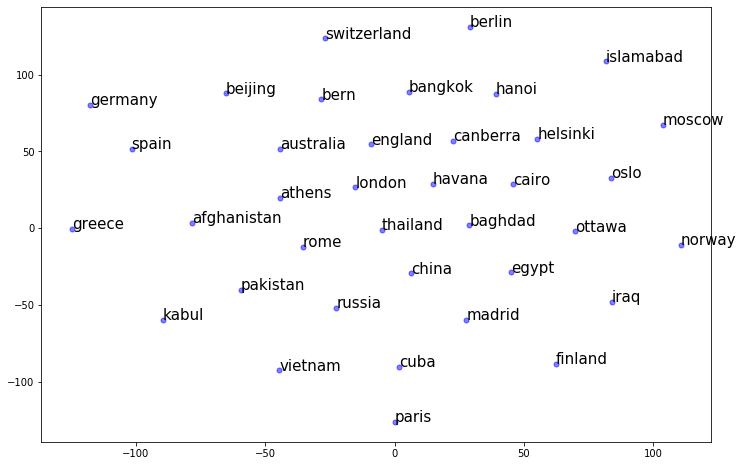

Word Charles_Poochigian
Nearby words: Sen._Chuck_Poochigian, Denise_Moreno_Ducheny, Senator_Chuck_Poochigian, Senator_Dave_Cogdill, Dean_Florez, Assemblyman_Juan_Arambula, Leader_Dave_Cogdill, Gilbert_Cedillo, Juan_Arambula, Carol_Migden
Random words: Jitendra, Graham_Saiko, REORGANIZATION, temporada, Sydenham_chorea, Jamey_Fitzgibbon, Catherine_Novelli, TEXAS_TOWNSHIP, Akhtar_Amin, NYSE_Amex_PZG_TSX


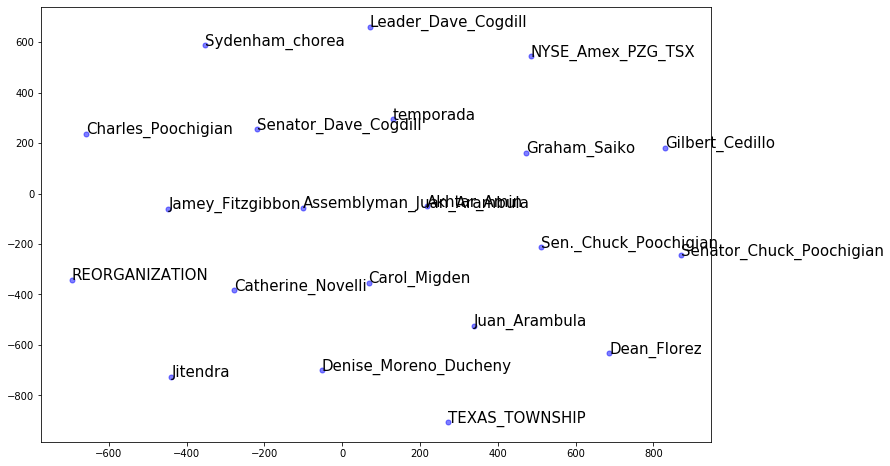

In [16]:
#given a model and a list of words, plot the word embeddings in two dimensions using TSNE
def plotWords(model, wordList):
    locs = [model[w] for w in wordList if w in model]
    tsne = TSNE(n_components=2, init='pca')
    (X, Y) = zip(*tsne.fit_transform(locs))
    plt.figure(figsize=(12,8))
    plt.scatter(X, Y, c='b', s=25, alpha=0.5)
    for (label,x,y) in zip(wordList, X, Y):
        plt.annotate(label, xy=(x,y), xytext=(0,0), textcoords='offset points', fontsize=15)
    plt.show()

#collect n nearest words to a given word according to a model
def nearbyWords(model, word, n=10):
    return [elem[0] for elem in model.most_similar(positive=word, topn=n)]

#collect n random words in a model
def randomWords(model, n=10):
    return list(np.random.choice(list(model.vocab.keys()), size=n, replace=False))

#collect all pairs from a given section of an analogy file
def collectAnalogySection(section, analogyFile='questions-words.txt'):
    pairs = {}
    keep = False
    with open(analogyFile, 'r') as f:
        for line in f:
            l = line.lower().strip()
            if keep and l[0]!=':':
                l = l.split(' ')
                pairs[l[0]] = l[1]
                pairs[l[2]] = l[3]
            if l[0]==':' and l[1:].strip()==section: keep = True
            elif l[0]==':' and keep: return pairs
    return pairs

pairs = collectAnalogySection('capital-common-countries')
keys = list(pairs.keys())[:20]
plotWords(model, keys+[pairs[k] for k in keys])

word = np.random.choice(list(model.vocab.keys()))
print('Word', word)
nearby = nearbyWords(model, word, n=10)
print('Nearby words: '+', '.join(nearby))
random = randomWords(model, n=10)
print('Random words: '+', '.join(random))
plotWords(model, [word]+nearby+random)

## Biological Sequences

BioVec takes the idea behind Word2Vec and applies it to biological sequence data. In particular, given some large dataset, BioVec learns an embedding of biological "words" (usually k-mers) based on the contexts in which they appear. Here our goal will be to learn an embedding of DNA 3-mers or codons using human coding sequences using the Word2Vec implementation in gensim. In this case, 3-mers will act as words and each coding sequence will represent a sentence.

Human coding sequences were obtained from Ensembl BioMart (Human genes GRCh38.p12). These sequences are available in the [GitHub repository for this tutorial](https://github.com/riti4538/ACM-BCB-2019-Tutorial) in Data/RawData/human_cds.txt. Data/sequences.txt contains each of these sequences on a separate line.

In [17]:
#a function to to yield one line from a file at a time
#up to k reading frames are considered
def genSentences(inFile, k, frames=1):
    frames = min(frames, k)
    with open(inFile, 'r') as f:
        for line in f:
            seq = line.strip()
            for i in range(frames):
                #Split seq into chunks of k characters starting at the ith position
                sent = list(map(''.join, zip(*[iter(seq[i:])]*k)))
                if sent: yield sent
                else: break

#an iterator over the lines if a file
class SentenceIter:
    def __init__(self, inFile, k, frames):
        self.inFile = inFile
        self.k = k
        self.frames = frames
    def __iter__(self):
        return genSentences(self.inFile, self.k, frames=self.frames)

#create a Word2Vec embedding based on the given set of sentences
def embedKmers(inFile, k, dim=30, frames=1):
    sentences = SentenceIter(inFile, k, frames=frames)
    model = models.Word2Vec(sentences,
                            size=dim,
                            window=10,
                            min_count=5,
                            sg=1,
                            hs=0,
                            negative=10,
                            iter=3,
                            workers=1) 
    return model

The following function generates and saves k-mer embeddings based on the information in *inFile*.

- *inFile*: a file containing one sentence per line.
- *kList*: a list of k values.
- *dimList*: a list of embedding dimensions.
- *frames*: the number of reading frames to consider (up to a maximum of k).

We will train two models. In the first, each coding sequence will represent a single sentence. In the second, coding sequences will map to 3 sentences, one for each reading frame.

In [18]:
#generate a Word2Vec embedding of kmers and save the result
#this function does not compress the embedding before saving
def saveEmbeddings(inFile, kList, outFileList=[], dimList=[30], frames=[1], saveEmbeddings=False, saveModels=False):
    models = []
    for i,k in enumerate(kList):
        model = embedKmers(inFile, k, dim=dimList[min(i,len(dimList)-1)], frames=frames[i])
        models.append(model)
        if saveEmbeddings:
            outFile = outFileList[i] if len(outFileList)>i else 'w2v_embedding_'+str(k)+'mers.locs'
            with open(outFile, 'w') as o:
                o.write('H_'+str(k)+',4 word2vec embedding with '+str(frames[i])+'frames\n')
                for word in sorted(model.wv.vocab):
                    o.write('\t'.join([word]+list(map(str,model[word])))+'\n')
        if saveModels: model.save('w2v_model_'+str(k)+'mers.model')
    return models

#read an embedding
def readEmbedding(inFile):
    locs = {}
    with open(inFile, 'r') as f:
        f.readline()
        for line in f:
            l = line.strip().split('\t')
            locs[l[0]] = list(map(float, l[1:]))
    return locs

seqFile = 'sequences.txt'
models = saveEmbeddings(seqFile, [3, 3], dimList=[6, 6], frames=[1, 3], saveEmbeddings=False, saveModels=False)
locs1 = {word: models[0][word] for word in models[0].wv.vocab}
locs3 = {word: models[1][word] for word in models[1].wv.vocab}

2019-08-30 12:33:34,031 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-08-30 12:33:34,031 : INFO : collecting all words and their counts
2019-08-30 12:33:34,033 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-08-30 12:33:34,533 : INFO : collected 64 word types from a corpus of 2558572 raw words and 4471 sentences
2019-08-30 12:33:34,534 : INFO : Loading a fresh vocabulary
2019-08-30 12:33:34,534 : INFO : min_count=5 retains 64 unique words (100% of original 64, drops 0)
2019-08-30 12:33:34,534 : INFO : min_count=5 leaves 2558572 word corpus (100% of original 2558572, drops 0)
2019-08-30 12:33:34,535 : INFO : deleting the raw counts dictionary of 64 items
2019-08-30 12:33:34,535 : INFO : sample=0.001 downsamples 61 most-common words
2019-08-30 12:33:34,536 : INFO : downsampling leaves estimated 774280 word corpus (30.3% of prior 2558572)
2019-08-30 12:33:34,537 : INFO : estimated required memory for 64 words and 6 

2019-08-30 12:34:23,365 : INFO : EPOCH 1 - PROGRESS: at 78.00% examples, 83532 words/s, in_qsize 2, out_qsize 0
2019-08-30 12:34:24,403 : INFO : EPOCH 1 - PROGRESS: at 81.03% examples, 83504 words/s, in_qsize 2, out_qsize 0
2019-08-30 12:34:25,413 : INFO : EPOCH 1 - PROGRESS: at 84.07% examples, 83373 words/s, in_qsize 2, out_qsize 0
2019-08-30 12:34:26,416 : INFO : EPOCH 1 - PROGRESS: at 86.55% examples, 82726 words/s, in_qsize 2, out_qsize 0
2019-08-30 12:34:27,436 : INFO : EPOCH 1 - PROGRESS: at 89.56% examples, 82669 words/s, in_qsize 2, out_qsize 0
2019-08-30 12:34:28,423 : INFO : EPOCH 1 - PROGRESS: at 92.51% examples, 82668 words/s, in_qsize 2, out_qsize 0
2019-08-30 12:34:29,429 : INFO : EPOCH 1 - PROGRESS: at 95.21% examples, 82682 words/s, in_qsize 2, out_qsize 0
2019-08-30 12:34:30,446 : INFO : EPOCH 1 - PROGRESS: at 98.66% examples, 82719 words/s, in_qsize 2, out_qsize 0
2019-08-30 12:34:30,916 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-08-30 12

Now we plot the results using t-SNE and label codons with the amino acid that they code for.

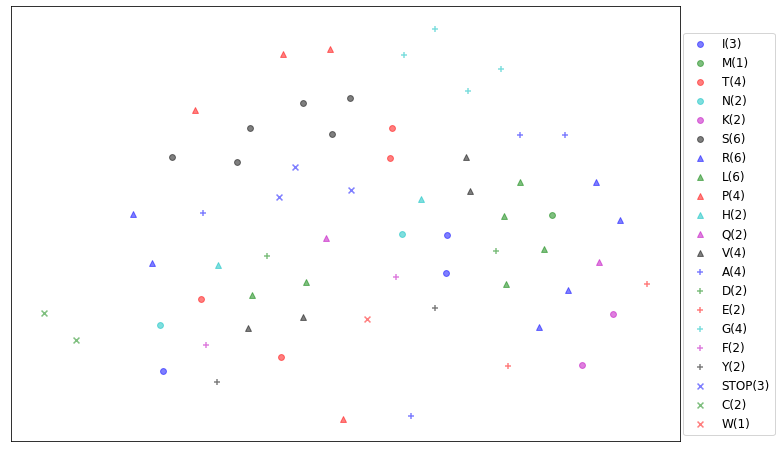

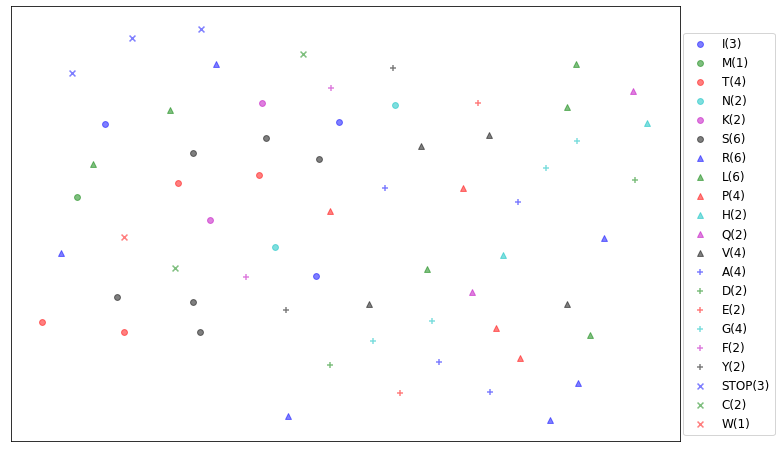

In [19]:
#use t-SNE to generate a simple visualization of a given embedding
#groups is a dictionary of label -> [kmers]
def visualize(locs, groups, textLabels={}, legend=True):
    kmers = sorted(list(locs))
    tsne = TSNE(n_components=2, init='pca')
    (X, Y) = zip(*tsne.fit_transform([locs[kmer] for kmer in kmers]))
    colors = ['b', 'g', 'r', 'c', 'm', 'k']
    markers = ['o', '^', '+', 'x', '*']
    symb = [(c,m) for m in markers for c in colors]
    plt.figure(figsize=(12,8))

    #plot kmers in the same group together with a common symbol/color
    for i,label in enumerate(groups):
        groupX = [X[kmers.index(kmer)] for kmer in groups[label]]
        groupY = [Y[kmers.index(kmer)] for kmer in groups[label]]
        plt.scatter(groupX, groupY, s=35, c=symb[i][0], marker=symb[i][1], label=label+'('+str(len(groups[label]))+')', alpha=0.5)
    
    #add any text labels
    for kmer in textLabels:
        plt.annotate(textLabels[kmer], xy=(X[kmers.index(kmer)], Y[kmers.index(kmer)]), xytext=(0,0), textcoords='offset points')

    ax = plt.gca()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.legend(bbox_to_anchor=(1.15,0), loc='lower right', prop={'size':12})
    plt.show()

codonMap = {'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
            'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
            'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
            'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
            'TAC':'Y', 'TAT':'Y', 'TAA':'STOP', 'TAG':'STOP', 'TGC':'C', 'TGT':'C', 'TGA':'STOP', 'TGG':'W'}
aaMap = {}
for kmer in codonMap:
    aa = codonMap[kmer]
    if aa not in aaMap: aaMap[aa] = []
    aaMap[aa].append(kmer)

visualize(locs1, aaMap, legend=True)
visualize(locs3, aaMap, legend=True)